<h1><center> Previsão do preço da estadia no Rio de Janeiro - Airbnb </h1>

# Contextualização


A partir da extração de dados do [Airbnb Rio de Janeiro](http://insideairbnb.com/get-the-data.html) será realizada a modelagem estatística para a previsão de preço da estadia de uma <u>nova unidade</u> a ser disponibilizada para aluguel pela plataforma, a fim de auxiliar <u>novos parceiros</u> na correta precificação de seus espaços.

Este relatório está estruturado nos seguintes tópicos:
1. [Base de Dados e Análise Exploratória](#a1)
2. [Metodologia](#a2)
3. [Considerações Finais](#a3)

Este projeto foi desenvolvido utilizando Python 3.6.

In [1]:
# Configurando o ambiente
import numpy as np # manipulação numérica
import pandas as pd # manipulação de dataframes (datasets)
import matplotlib.pyplot as plt # visualização de gráficos
import seaborn as sns # visualização de gráficos
from sklearn.model_selection import train_test_split # separar dados de treino e teste
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

# Omitir warnings
import warnings
warnings.filterwarnings('ignore')

# [1. Base de Dados](#a1)
    
A extração de dados foi realizada em 28/02/2021 e a limpeza de dados inicial foi realizada diretamente no excel, a fim de manter apenas registros que refletiam espaços para locação. Após o tratamento do arquivo listings.csv.gz foram obtidos 26.106 registros com detalhamento sobre locações do Rio de Janeiro.

In [2]:
# Carregando o dataset e conferindo a quantidade de registros na importação
bdados = pd.read_csv("listings_rio.csv", sep=';', encoding='utf-8', decimal=".")   
bdados.shape

(26103, 74)

Considerando o objetivo de desenvolver um modelo para auxiliar a precificação de novos espaços por novos parceiros, foram mantidas na base as seguintes informações:

Variável|Descrição
:--------- | :------
neighbourhood_cleansed|Bairro
property_type|Tipo de propriedade
room_type|Tipo de quarto
accommodates|Capacidade de acomodação
bathrooms|Quantidade de banheiros
bedrooms|Quantidade de quartos
beds|Quantidade de camas
minimum_nights|Número mínimo de noites para locação
maximum_nights|Número máximo de noites para locação
price|Preço

Buscou-se avaliar a consistência dos dados obtidos, a partir da avaliação e tratamento para situações de dados duplicados ou faltantes (*missing*) e inconsistências observadas, a fim de iniciar a análise exploratória.

#### Repetições

Não localizou-se duplicação de dados na base importada, assim não houve necessidade de exclus de registros em virtude de repetição. 

In [3]:
duplicados = bdados[bdados.duplicated(keep='first')]
duplicados.shape

(0, 74)

#### *Missing*

In [4]:
# Mantendo as colunas de interesse no data frame
df=bdados[["neighbourhood_cleansed", "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds",
           "minimum_nights", "maximum_nights", "price"]]
df.isnull().sum()

neighbourhood_cleansed     7478
property_type              7478
room_type                  7478
accommodates               7478
bathrooms                 26103
bedrooms                   8754
beds                       7684
minimum_nights             7478
maximum_nights             7478
price                      7478
dtype: int64

Em cerca de 29% dos espaços listados não havia informações de preço disponíveis na base, ocasionando na retirada desses casos do estudo. 

Observou-se ainda que a variável indicadora da quantidade de banheiros apresentou *missing* em 99,9% dos casos, tendo sido excluída do estudo.

In [5]:
# Exclui a variável bathrooms e elimina linhas com missing price              
df.drop('bathrooms',inplace=True, axis=1)
df=df[df.price.notnull()]
df.shape

(18625, 9)

In [6]:
df.isnull().sum()

neighbourhood_cleansed       0
property_type                0
room_type                    0
accommodates                 0
bedrooms                  1276
beds                       206
minimum_nights               0
maximum_nights               0
price                        0
dtype: int64

Considerando a pequena representatividade do total de dados de locações com observações faltantes para número de quartos (6%) e camas (1%), optou-se pela exclusão dessas observações em que não se obteve informações. Desse modo a base de dados de estudos final é composta por 17.170 registros.

In [7]:
# Elimina missing nas demais variáveis
df=df[df.bedrooms.notnull()]
df=df[df.beds.notnull()]
df.shape

(17170, 9)

#### Inconsistências e *Datatypes*

Observando as primeiras linhas da base de dados é possível fazer uma rápida checagem de conferência de dados, percebendo a necessidade de tratamento da variável ```price``` para remoção do símbolo "$".

In [8]:
df.head()

,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,maximum_nights,price
0,Copacabana,Entire condominium,Entire home/apt,5.0,2.0,2.0,5.0,180.0,$201.00
5,Ipanema,Entire apartment,Entire home/apt,13.0,6.0,6.0,2.0,89.0,"$1,752.00"
9,Ipanema,Entire apartment,Entire home/apt,6.0,3.0,3.0,3.0,89.0,$654.00
10,Barra da Tijuca,Entire house,Entire home/apt,12.0,4.0,7.0,1.0,730.0,"$3,360.00"
12,Ipanema,Entire apartment,Entire home/apt,6.0,3.0,2.0,4.0,1125.0,$364.00


In [9]:
df['price'] = df['price'].str.replace('$', '').str.replace(',', '')

Também para garantir a correta aplicação do modelo é necessário especificar o tipo de cada variável, sendo que as variáveis relacionadas à bairro, tipo de propriedade e tipo de quarto foram consideradas categóricas e as demais variáveis numéricas.

In [10]:
vnum = ['accommodates', 'bedrooms', 'beds', 'minimum_nights','maximum_nights','price']
vcat = ['neighbourhood_cleansed', 'property_type', 'room_type']
 
def to_type(DataFrame, columns, type):
    for col in columns:
        DataFrame[col] = DataFrame[col].astype(type)
        
to_type(df, vnum, 'float')
to_type(df, vcat, 'category')

#### Variávies numéricas: Análise exploratória e *outliers*

Inicialmente observou-se as estatísticas descritivas e as distribuições das variáveis numéricas, percebendo-se uma grande variação em algumas delas, sendo a maior observada no preço, cujo desvio padrão foi de \$2.241. 

In [11]:
df.describe()

,accommodates,bedrooms,beds,minimum_nights,maximum_nights,price
count,17170.000000,17170.000000,17170.000000,17170.000000,1.717000e+04,17170.000000
mean,4.180606,1.694525,2.550146,4.919220,5.886517e+04,685.471578
std,2.483060,1.028930,2.071180,19.320903,7.631582e+06,2241.909280
min,1.000000,1.000000,0.000000,1.000000,1.000000e+00,33.000000
25%,2.000000,1.000000,1.000000,1.000000,3.000000e+01,168.000000
50%,4.000000,1.000000,2.000000,2.000000,1.125000e+03,300.000000
75%,5.000000,2.000000,3.000000,4.000000,1.125000e+03,625.000000
max,16.000000,30.000000,41.000000,730.000000,1.000000e+09,127191.000000


Considerando a distribuição observada e buscando minimizar os efeitos de valores extremos, optou-se por realizar a exclusão de observações a mais de 3 desvios padrão considerando as variáveis ```beds, minimum_nights, maximum_nights``` e ```price```. 

In [12]:
def outrm(DataFrame, col_name):
  intervalo = 3*DataFrame[col_name].std()
  media = DataFrame[col_name].mean()
  DataFrame.loc[df[col_name] > (media + intervalo), col_name] = np.nan

for col in ['beds', 'minimum_nights','maximum_nights','price']:
  outrm(df, col)

for col in ['beds', 'minimum_nights','maximum_nights','price']:
    df=df[df[col].notnull()]
    
df.shape

(16713, 9)

Após o tratamento de outliers restaram 16.713 observações na base. As estatísticas desciritivas e a distribuição são apresentadas na sequência.

In [13]:
df.describe()

,accommodates,bedrooms,beds,minimum_nights,maximum_nights,price
count,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000,16713.000000
mean,4.050440,1.649554,2.389098,3.794531,622.759110,547.677915
std,2.247765,0.908725,1.531321,5.174807,675.785165,736.993523
min,1.000000,1.000000,0.000000,1.000000,1.000000,35.000000
25%,2.000000,1.000000,1.000000,1.000000,30.000000,166.000000
50%,4.000000,1.000000,2.000000,2.000000,1125.000000,300.000000
75%,5.000000,2.000000,3.000000,4.000000,1125.000000,600.000000
max,16.000000,20.000000,8.000000,60.000000,47036.000000,7107.000000


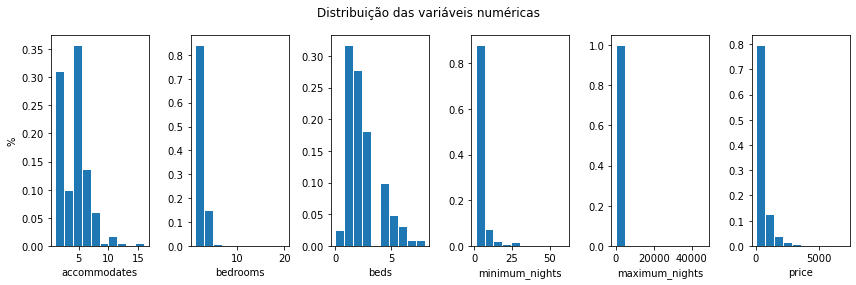

In [14]:
# Histogramas com frequência (%)
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1,6, figsize = (12,4))

ax1.hist(df['accommodates'], weights=np.ones(len(df['accommodates'])) / len(df['accommodates']),edgecolor = 'white', align = 'mid')
ax1.set_xlabel('accommodates')
ax1.set_ylabel('%')

ax2.hist(df['bedrooms'], weights=np.ones(len(df['bedrooms'])) / len(df['bedrooms']),edgecolor = 'white', align = 'mid')
ax2.set_xlabel('bedrooms')

ax3.hist(df['beds'], weights=np.ones(len(df['beds'])) / len(df['beds']),edgecolor = 'white', align = 'mid')
ax3.set_xlabel('beds')

ax4.hist(df['minimum_nights'], weights=np.ones(len(df['minimum_nights'])) / len(df['minimum_nights']),edgecolor = 'white', align = 'mid')
ax4.set_xlabel('minimum_nights')

ax5.hist(df['maximum_nights'], weights=np.ones(len(df['maximum_nights'])) / len(df['maximum_nights']), edgecolor = 'white', align = 'mid')
ax5.set_xlabel('maximum_nights')

ax6.hist(df['price'], weights=np.ones(len(df['price'])) / len(df['price']), edgecolor = 'white', align = 'mid')
ax6.set_xlabel('price')

fig.suptitle('Distribuição das variáveis numéricas')
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

Observou-se ainda a correlação entre as variáveis numéricas e o preço, sendo possível observar uma correlação:
* Moderada com a capacidade da obupação, número de quartos e camas;
* Baixa com o número de camas e mínimo de noites e 
* Praticamente nula com o máximo número de noites. 

Assim, entende-se não ser pertinente avaliar o número máximo de noites para a precificação de um espaço.

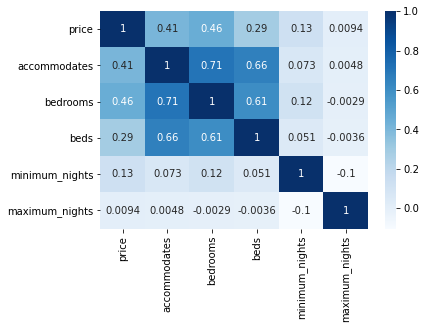

In [15]:
# Correlograma
correl=df[['price', 'accommodates', 'bedrooms', 'beds', 'minimum_nights','maximum_nights']].corr() 
sns.heatmap(correl, annot=True, cmap="Blues")
plt.show()
vcat = ['neighbourhood_cleansed', 'property_type', 'room_type']

A distribuição bivariada também foi analisada, apenas para fins ilustrativos pois o obetivo é utilizar as variáveis simultaneamente para predição.

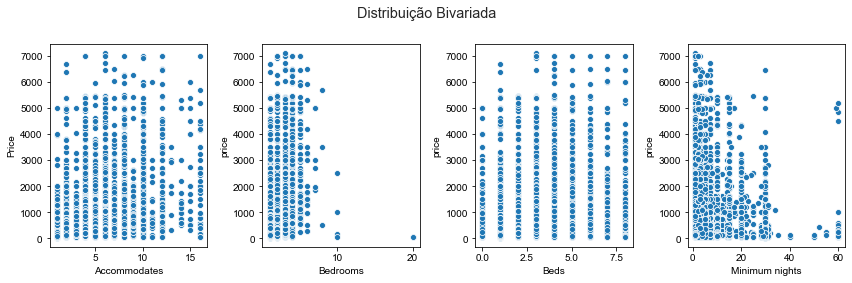

In [16]:
# Eliminando a variável maximum_nights
df.drop('maximum_nights',inplace=True, axis=1)

# Bivariada
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4 , figsize = (12,4))
sns.set(style="darkgrid")

sns.scatterplot(x=df['accommodates'], y=df['price'], ax=ax1)
ax1.set_xlabel('Accommodates')
ax1.set_ylabel('Price')

sns.scatterplot(x=df['bedrooms'], y=df['price'], ax=ax2)
ax2.set_xlabel('Bedrooms')

sns.scatterplot(x=df['beds'], y=df['price'], ax=ax3)
ax3.set_xlabel('Beds')

sns.scatterplot(x=df['minimum_nights'], y=df['price'], ax=ax4)
ax4.set_xlabel('Minimum nights')

fig.suptitle('Distribuição Bivariada')
plt.tight_layout()
fig.subplots_adjust(top=0.85)
plt.show()

#### Variávies categóricas

Para as variáveis categóricas, inicialmente bucou-se identificar a granularidade das observações, de modo a verificar se seria necessário relizar novos agrupamentos ou tratamento das variáveis. A quantidade de categorias para cada variável é apresentada na tabela a seguir.

In [17]:
pd.DataFrame({"Qtd. Categorias": [len(df['neighbourhood_cleansed'].value_counts()), len(df['property_type'].value_counts()),
                   len(df['room_type'].value_counts())]}, index=(['neighbourhood_cleansed', 'property_type', 'room_type']))


,Qtd. Categorias
neighbourhood_cleansed,147
property_type,81
room_type,4


Observou-se uma alta granularidade de bairros e tipos de propriedades, optando-se por manter na base de dados apenas categorias que possuem no mínimo 100 registros, considerando o caráter ilustrativo desta aplicação. Restaram assim 14.046 registros.

In [18]:
df['f_neighbourhood_cleansed']=df['neighbourhood_cleansed'].map(df['neighbourhood_cleansed'].value_counts().to_dict())
df['f_property_type']=df['property_type'].map(df['property_type'].value_counts().to_dict())
df['f_room_type']=df['room_type'].map(df['room_type'].value_counts().to_dict())
df=df.query('f_neighbourhood_cleansed > 100 & f_property_type > 100 & f_room_type > 100')
df=df.iloc[:,0:8]
df.shape

(14138, 8)

Na sequência é apresentada a distribuição de frequências das categorias presentes na base de dados.

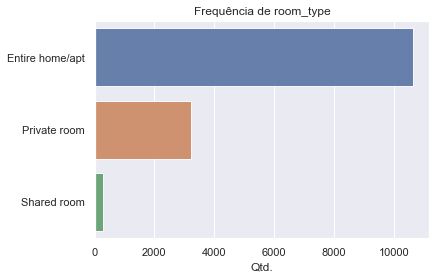

In [19]:
room_type=pd.DataFrame(df['room_type'].value_counts()).query('room_type>0')
room_type.index = room_type.index.tolist()
sns.set(style="darkgrid")
sns.barplot(room_type.room_type,room_type.index, alpha=0.9)
plt.title('Frequência de room_type')
plt.xlabel('Qtd.', fontsize=12)
plt.show()

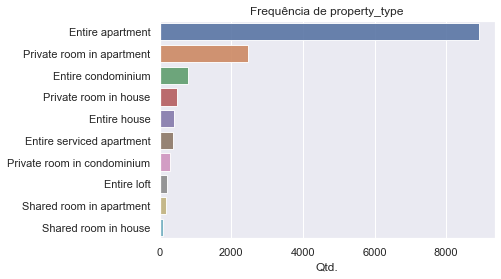

In [20]:
property_type=pd.DataFrame(df['property_type'].value_counts()).query('property_type>0')
property_type.index = property_type.index.tolist()
sns.set(style="darkgrid")
sns.barplot(property_type.property_type,property_type.index, alpha=0.9)
plt.title('Frequência de property_type')
plt.xlabel('Qtd.', fontsize=12)
plt.show()

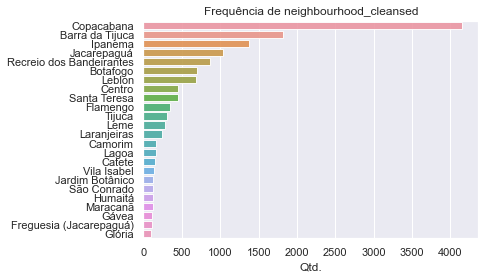

In [21]:
neighbourhood_cleansed=pd.DataFrame(df['neighbourhood_cleansed'].value_counts()).query('neighbourhood_cleansed>0')
neighbourhood_cleansed.index = neighbourhood_cleansed.index.tolist()
sns.set(style="darkgrid")
sns.barplot(neighbourhood_cleansed.neighbourhood_cleansed, neighbourhood_cleansed.index, alpha=0.9)
plt.title('Frequência de neighbourhood_cleansed')
plt.xlabel('Qtd.', fontsize=12)
plt.show()

In [22]:
df.head()

,neighbourhood_cleansed,property_type,room_type,accommodates,bedrooms,beds,minimum_nights,price
0,Copacabana,Entire condominium,Entire home/apt,5.0,2.0,2.0,5.0,201.0
5,Ipanema,Entire apartment,Entire home/apt,13.0,6.0,6.0,2.0,1752.0
9,Ipanema,Entire apartment,Entire home/apt,6.0,3.0,3.0,3.0,654.0
10,Barra da Tijuca,Entire house,Entire home/apt,12.0,4.0,7.0,1.0,3360.0
12,Ipanema,Entire apartment,Entire home/apt,6.0,3.0,2.0,4.0,364.0


# [2. Metodologia](#a2)

Para o modelo de precificação de novas unidades para locação por novos parceiros foi utilizado modelo de regressão linear com o algoritimo *Light Boosting Gradient Model* (LGBM).

Foram utilizados 70% dos dados para estimação do modelo e 30% para teste, a fim de avaliar o desempenho do modelo em um novo conjunto de dados.

In [23]:
# Seleciona as variáveis explicativas
X = df.iloc[:,0:7]
# Seleciona a variável Target 
y = df[['price']]
# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 280221)
# Conferindo a quantidade de registros em cada df
print("Variáveis treino =",X_train.shape, "\nTarget treino = ", y_train.shape, "\nVariáveis teste =", X_test.shape, "\nTarget teste = ", y_test.shape)

Variáveis treino = (9896, 7) 
Target treino =  (9896, 1) 
Variáveis teste = (4242, 7) 
Target teste =  (4242, 1)


In [24]:
# Realiza o fit do modelo
model = LGBMRegressor(metric='r2')
model.fit(X_train, y_train)

# Realiza as predições
y_pred_train = model.predict(X_train) 
y_pred_test = model.predict(X_test) 

#Calcula R^2
rtrain=round(r2_score(y_train, y_pred_train),3)
rtest=round(r2_score(y_test, y_pred_test),3)
print("R^2 treino:",rtrain,"\nR^2 teste:",rtest)

R^2 treino: 0.488 
R^2 teste: 0.273


Na base de treino foi obtido um coeficiente de determinação de 48,3%, indicando que o modelo foi capaz de explicar cerca de 50% da variação do preço dos espaços a partir das variáveis selecionadas. Observou-se ainda uma variação de 20% entre o R² obtido na base de treino e de teste, sendo que para a base de teste a performance não foi mantida.

Considerando a finalidade desse estudo, não serão aprofundadas técnicas para *tunning* do modelo obtido, entretanto é esperada maior robustez nessa classe de modelos para aplicação prática.

A importância das variáveis no modelo final é apresentada abaixo.

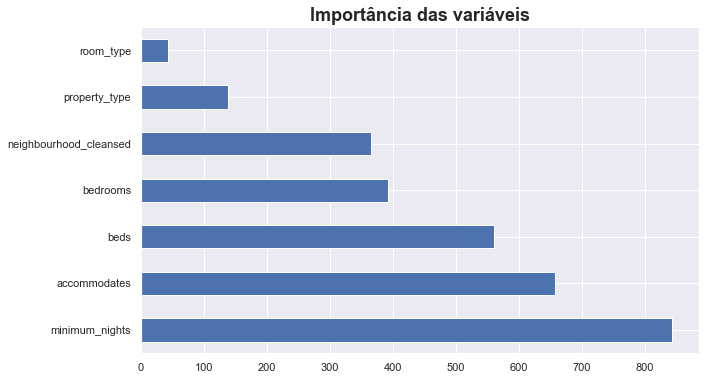

In [25]:
feat_imp = pd.Series(model.feature_importances_,
                     index=df.columns.drop('price'))
feat_imp.nlargest(15).plot(kind='barh', figsize=(10, 6))
plt.xlabel('')
plt.title("Importância das variáveis", fontsize=18, fontweight='bold')
plt.show()

Na sequência são apresentados os gráficos com os valores pretidos vs observado para a base de treino e também a diferença observada entre esses valores na base de treino e teste. As diferenças se concentram em torno de zero.

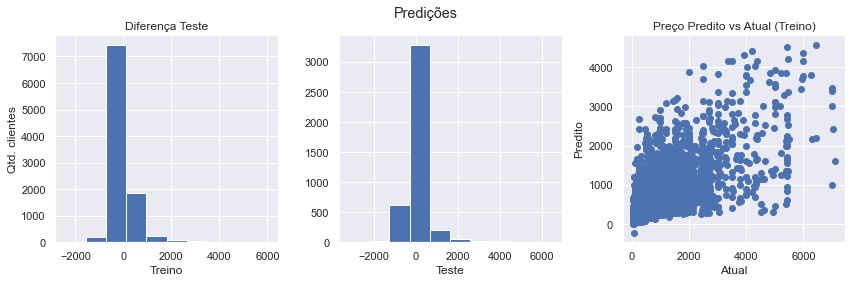

In [26]:
# Analisando as previsões
dif_treino=pd.DataFrame(y_train.price.values-y_pred_train)
dif_teste=pd.DataFrame(y_test.price.values-y_pred_test)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,4))

ax1.hist(dif_treino[0], edgecolor = 'white', align = 'mid')
ax1.set_title("Diferença Treino")
ax1.set_xlabel('Treino')
ax1.set_ylabel('Qtd. clientes')

ax2.hist(dif_teste[0], edgecolor = 'white', align = 'mid')
ax1.set_title("Diferença Teste")
ax2.set_xlabel('Teste')

ax3.scatter(y_train, y_pred_train)
plt.title('Preço Predito vs Atual (Treino)')
plt.xlabel('Atual')
plt.ylabel('Predito')

fig.suptitle('Predições')
plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# [3. Considerações Finais](#a3)

A partir da base de dados do Arirbnb do Rio de Janeiro buscou-se desenvolver um modelo para estimação de preço, baseado em algumas características da locação, de modo a auxiliar novos parceiros na precificação de seus espaços.

**3.1. Como foi a definição da sua estratégia de modelagem?**

Considerando a natureza da variável resposta, a estratégia de modelagem foi direcionada para modelos de regressão linear múltipla. Buscou-se enfatizar a importância do tratamento dos dados que são utilizados na modelagem, de modo a permitir que o modelo obtido reflita com maior proximidade o cenário real e apresente desempenho satisfatório para aplicação. 

**3.2. Como foi definida a função de custo utilizada?**

Foi utilizado o algoritimo *Light Boosting Gradient Model* (LGBM), buscando a maximização do coeficiente de determinação (R²).

**3.3.  Qual foi o critério utilizado na seleção do modelo final?**

Foi realizada apenas uma ilustração de aplicação da técnica, não tendo sido aplicado *tunning* ao modelo, eliminando a necessidade de seleção de modelo final. Seriam avaliados os desempenhos de alguns modelos por meio do R² após testados alguns hiperparâmetros pré-selecionados, de modo que o modelo final escolhido seria aquele que apresentasse melhor desempenho.

**3.4.  Qual foi o critério utilizado para validação do modelo? Por que escolheu utilizar este método?**

Considerando o volume de dados disponíveis foi feita a utilização de 70% dos dados para treino e 30% dos dados para teste/validação do modelo. Optou-se pela realização de amostragem aleatória simples para a divisão da base, entretanto poderia ter sido realizada uma amostragem estratificada com base nas categorias das variáveis categóricas consideradas, de modo a garantir a representatividade dos cenários nas bases de treino e teste.

**3.5.  Quais evidências você possui de que seu modelo é suficientemente bom?**

A partir do R² é possível observar que cerca de 50% da variação do preço dos espaços pôde ser explicada a partir das variáveis selecionadas. Entretanto, na base de teste houve uma redução do R² de modo que seria necessário aprofundar o estudo para apresentar um modelo suficientemente bom para aplicação. 

Considerando o objetivo proposto e também a concentração da diferença entre preço predito e observado em torno de zero, tanto para a base de treino como para a base de teste, entende-se que o resultado foi uma exemplificação coerente para apresentação da técnica.



<p style="text-align:right">Karen Regina</p>
<p style="text-align:right">Fev 2021</p>